# Causal Analysis: Flipped Classroom Impact on Student Performance

This notebook investigates whether implementing flipped classroom methodology caused improvements in student academic performance. We analyze data from 2018-2023, where 2018-2020 represents traditional teaching and 2021-2023 represents flipped classroom implementation.

## Key Research Question
**Does implementing flipped classroom methodology affect (causally improve) student grades and pass rates?**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Overview

**What we're doing:** Loading our student performance data to understand the structure and check for any data quality issues.

**Why this matters:** Before analyzing causation, we need to ensure our data is clean and understand exactly what we're working with.

In [2]:
# Load the combined dataset
df = pd.read_csv('../data/combined_before_after_fc.csv')

print("Dataset Overview:")
print(f"Total students: {len(df)}")
print(f"Years covered: {sorted(df['academic_year'].unique())}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
display(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

Dataset Overview:
Total students: 307
Years covered: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Columns: ['academic_year', 'first_name', 'last_name', 'final_grade', 'passed', 'fc_implementation']

First few rows:


,academic_year,first_name,last_name,final_grade,passed,fc_implementation
0,2018,Petra,Antolić,1.0,0.0,0
1,2018,Iva,Bogović,1.0,0.0,0
2,2018,Martina,Buček,1.0,0.0,0
3,2018,Barbara,Črešnjek,1.0,0.0,0
4,2018,Ines,Diaković,1.0,0.0,0



Missing values:
academic_year        0
first_name           0
last_name            0
final_grade          2
passed               2
fc_implementation    0
dtype: int64

Data types:
academic_year          int64
first_name            object
last_name             object
final_grade          float64
passed               float64
fc_implementation      int64
dtype: object


## 2. Data Cleaning and Preparation

**What we're doing:** Cleaning the data by handling missing values and creating clear groups for our causal analysis.

**Why this matters:** Missing or inconsistent data can bias our causal conclusions, so we need to address these issues upfront.

In [3]:
# Check for missing values and data issues
print("Missing values by column:")
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0])

# Clean the data - remove rows with missing grades
df_clean = df.dropna(subset=['final_grade', 'passed']).copy()

print(f"\nRows after cleaning: {len(df_clean)} (removed {len(df) - len(df_clean)} rows with missing grades)")

# Create period labels for clearer analysis
df_clean['period'] = df_clean['fc_implementation'].map({
    0: 'Traditional (2018-2020)',
    1: 'Flipped Classroom (2021-2023)'
})

print("\nStudents per period:")
print(df_clean['period'].value_counts())

print("\nStudents per year:")
print(df_clean.groupby(['academic_year', 'period']).size())

Missing values by column:
final_grade    2
passed         2
dtype: int64

Rows after cleaning: 305 (removed 2 rows with missing grades)

Students per period:
period
Traditional (2018-2020)          160
Flipped Classroom (2021-2023)    145
Name: count, dtype: int64

Students per year:
academic_year  period                       
2018           Traditional (2018-2020)          46
2019           Traditional (2018-2020)          62
2020           Traditional (2018-2020)          52
2021           Flipped Classroom (2021-2023)    45
2022           Flipped Classroom (2021-2023)    49
2023           Flipped Classroom (2021-2023)    51
dtype: int64


## 3. Descriptive Statistics: Before vs After Flipped Classroom

**What we're doing:** Calculating basic statistics (averages, pass rates) for both the traditional and flipped classroom periods.

**Why this matters:** These numbers give us the first indication of whether there's a difference in performance. However, we'll need statistical tests to determine if these differences are meaningful and not just due to random chance.

In [4]:
# Calculate descriptive statistics by period
desc_stats = df_clean.groupby('period').agg({
    'final_grade': ['count', 'mean', 'std', 'median'],
    'passed': ['sum', 'mean']
}).round(3)

# Flatten column names for better display
desc_stats.columns = ['_'.join(col).strip() for col in desc_stats.columns.values]
desc_stats['pass_rate_percent'] = (desc_stats['passed_mean'] * 100).round(1)

print("Descriptive Statistics by Period:")
print("================================")
display(desc_stats[['final_grade_count', 'final_grade_mean', 'final_grade_std', 
                   'final_grade_median', 'passed_sum', 'pass_rate_percent']])

# Calculate year-by-year statistics
yearly_stats = df_clean.groupby(['academic_year', 'period']).agg({
    'final_grade': ['count', 'mean'],
    'passed': ['sum', 'mean']
}).round(3)

yearly_stats.columns = ['_'.join(col).strip() for col in yearly_stats.columns.values]
yearly_stats['pass_rate_percent'] = (yearly_stats['passed_mean'] * 100).round(1)

print("\nYear-by-Year Statistics:")
print("========================")
display(yearly_stats[['final_grade_count', 'final_grade_mean', 'pass_rate_percent']])

Descriptive Statistics by Period:


,final_grade_count,final_grade_mean,final_grade_std,final_grade_median,passed_sum,pass_rate_percent
period,,,,,,
Flipped Classroom (2021-2023),145,2.124,1.130,2.0,80.0,55.2
Traditional (2018-2020),160,1.562,1.201,1.0,34.0,21.2



Year-by-Year Statistics:


,,final_grade_count,final_grade_mean,pass_rate_percent
academic_year,period,,,
2018,Traditional (2018-2020),46,1.848,34.8
2019,Traditional (2018-2020),62,1.339,11.3
2020,Traditional (2018-2020),52,1.577,21.2
2021,Flipped Classroom (2021-2023),45,1.778,44.4
2022,Flipped Classroom (2021-2023),49,2.245,57.1
2023,Flipped Classroom (2021-2023),51,2.314,62.7


## 4. Visual Comparison: Grade Distributions

**What we're seeing:** These charts show how student grades are distributed in both periods. The box plot shows the median (middle line), quartiles (box edges), and outliers. The histogram shows how many students got each grade.

**What to look for:** 
- Is the median grade higher in the flipped classroom period?
- Are there more students getting higher grades (4s and 5s) after flipped classroom implementation?
- How much overlap is there between the two distributions?

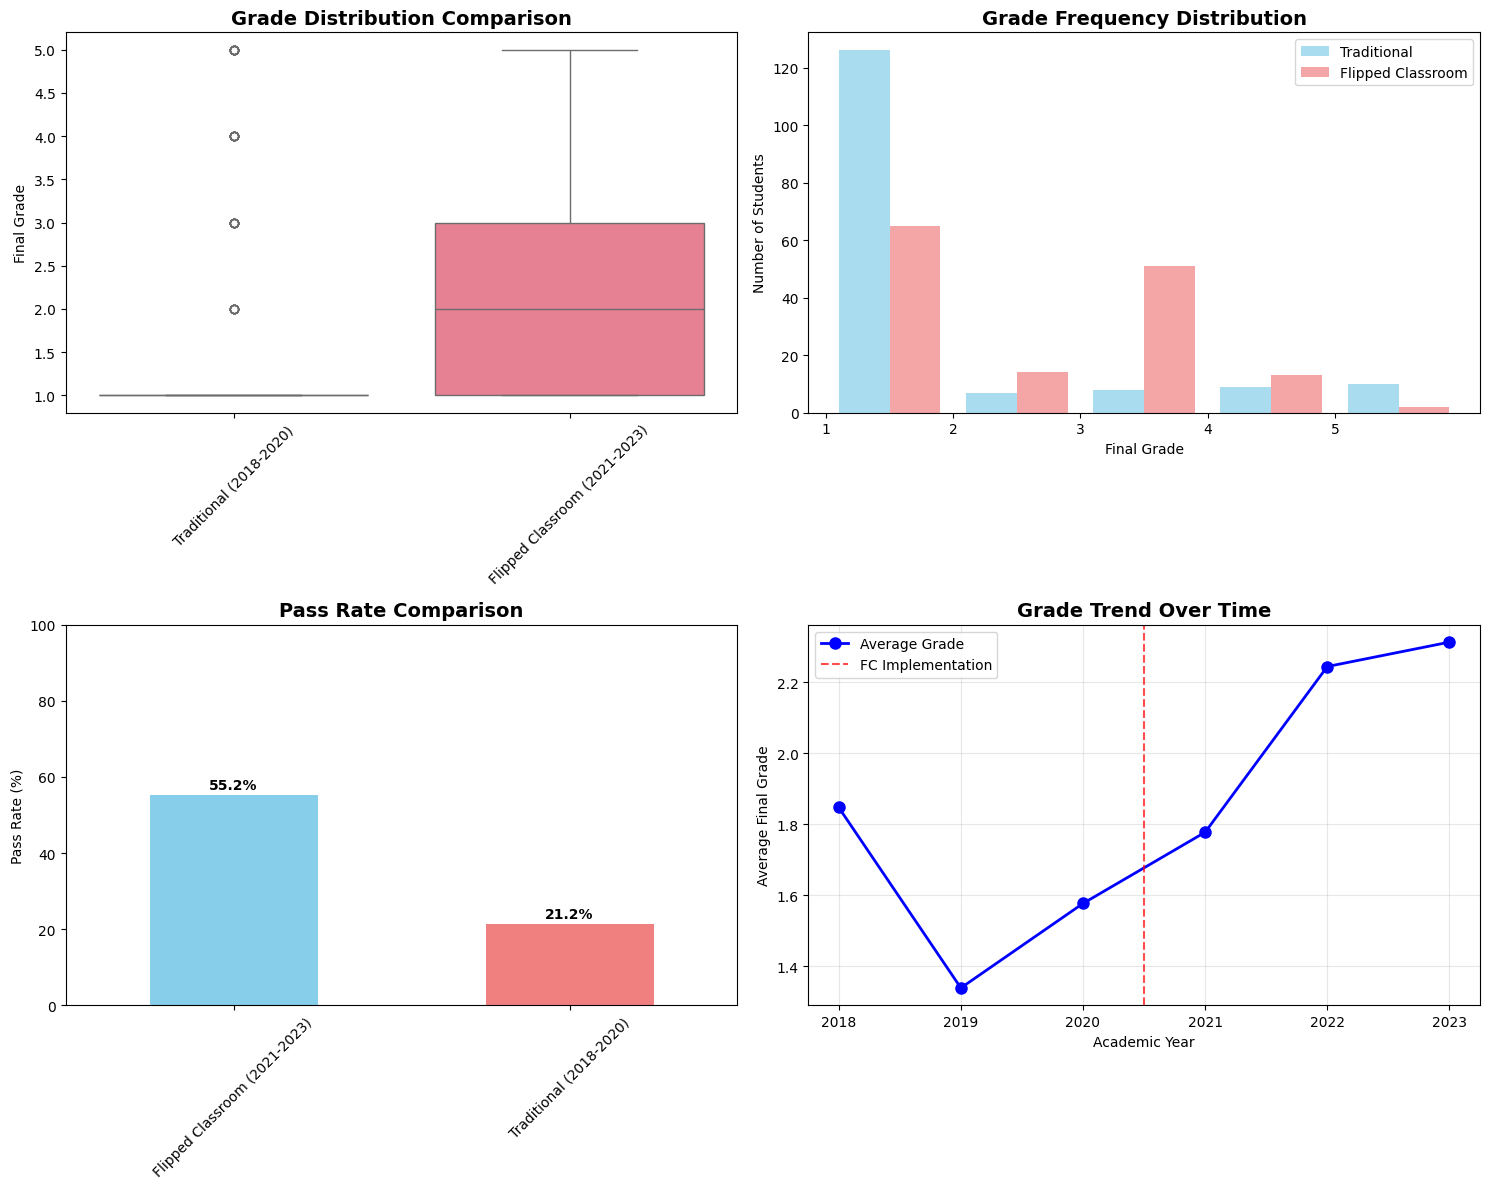


Detailed Pass Rate Analysis:
Flipped Classroom (2021-2023): 55.2% (80.0/145 students)
Traditional (2018-2020): 21.2% (34.0/160 students)

Difference: +-33.9 percentage points higher in Flipped Classroom period


In [5]:
# Create comprehensive visualization of grade distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Box plot comparing grade distributions
sns.boxplot(data=df_clean, x='period', y='final_grade', ax=axes[0,0])
axes[0,0].set_title('Grade Distribution Comparison', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Final Grade')
axes[0,0].set_xlabel('')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Histogram of grades by period
traditional = df_clean[df_clean['fc_implementation'] == 0]['final_grade']
flipped = df_clean[df_clean['fc_implementation'] == 1]['final_grade']

axes[0,1].hist([traditional, flipped], bins=range(1, 7), alpha=0.7, 
              label=['Traditional', 'Flipped Classroom'], color=['skyblue', 'lightcoral'])
axes[0,1].set_title('Grade Frequency Distribution', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Final Grade')
axes[0,1].set_ylabel('Number of Students')
axes[0,1].legend()
axes[0,1].set_xticks(range(1, 6))

# 3. Pass rate comparison
pass_rates = df_clean.groupby(['period'])['passed'].mean() * 100
pass_rates.plot(kind='bar', ax=axes[1,0], color=['skyblue', 'lightcoral'])
axes[1,0].set_title('Pass Rate Comparison', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Pass Rate (%)')
axes[1,0].set_xlabel('')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylim(0, 100)

# Add percentage labels on bars
for i, v in enumerate(pass_rates):
    axes[1,0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Year-by-year trend
yearly_means = df_clean.groupby(['academic_year'])['final_grade'].mean()
yearly_pass_rates = df_clean.groupby(['academic_year'])['passed'].mean() * 100

axes[1,1].plot(yearly_means.index, yearly_means.values, marker='o', linewidth=2, markersize=8, color='blue', label='Average Grade')
axes[1,1].axvline(x=2020.5, color='red', linestyle='--', alpha=0.7, label='FC Implementation')
axes[1,1].set_title('Grade Trend Over Time', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Academic Year')
axes[1,1].set_ylabel('Average Final Grade')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display the exact pass rate numbers
print("\nDetailed Pass Rate Analysis:")
print("============================")
for period in pass_rates.index:
    rate = pass_rates[period]
    count = df_clean[df_clean['period'] == period]['passed'].sum()
    total = len(df_clean[df_clean['period'] == period])
    print(f"{period}: {rate:.1f}% ({count}/{total} students)")

difference = pass_rates.iloc[1] - pass_rates.iloc[0]
print(f"\nDifference: +{difference:.1f} percentage points higher in Flipped Classroom period")

## 5. Distribution Analysis and Test Selection

**What we're doing:** Before choosing statistical tests, we need to examine whether our grade data follows a normal distribution. This determines whether we should use parametric tests (which assume normality) or non-parametric tests (which don't require normality).

**Why this matters:** Using the wrong statistical test can lead to incorrect conclusions. If data isn't normally distributed, parametric tests like t-tests may give unreliable results, while non-parametric tests like Mann-Whitney U are more robust.

**What we're checking:** Distribution shape, skewness, normality tests, and visual inspection to make informed decisions about statistical methods.

Distribution Analysis for Grade Data

COMBINED GRADE DISTRIBUTION:
------------------------------
📊 Final Grade Distribution Analysis

📊 final_grade:
  Sample size: 305
  Mean ± SD: 1.830 ± 1.199
  Median: 1.000
  Skewness: 1.133 (Highly skewed)
  Kurtosis: 0.036 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0000 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)



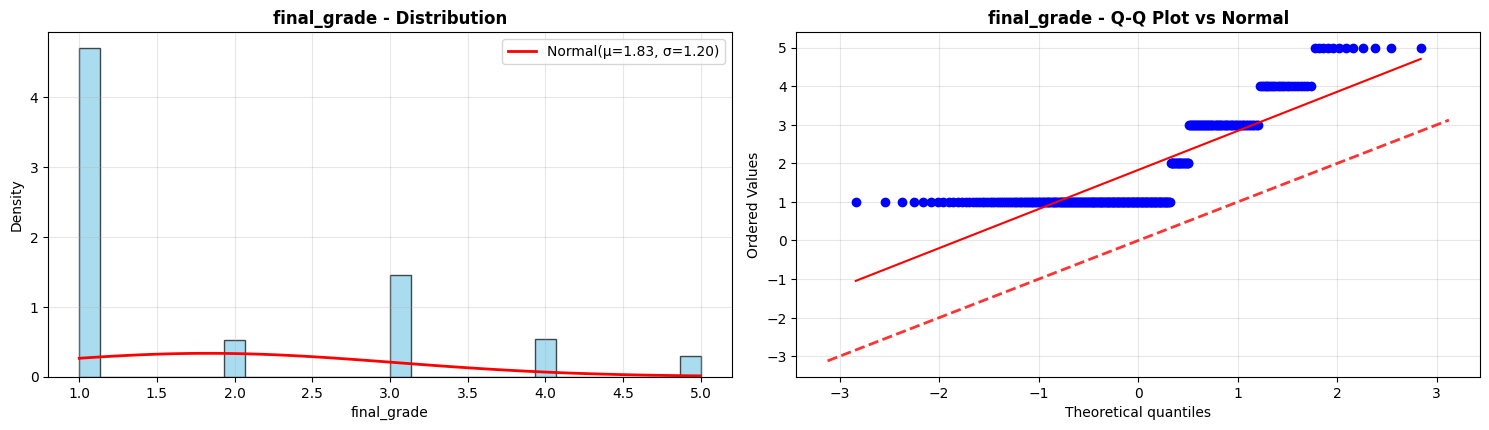


SEPARATE ANALYSIS BY PERIOD:

🔵 TRADITIONAL PERIOD (2018-2020):
📊 Traditional Period Grade Distribution

📊 final_grade_traditional:
  Sample size: 160
  Mean ± SD: 1.562 ± 1.201
  Median: 1.000
  Skewness: 1.961 (Highly skewed)
  Kurtosis: 2.355 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0000 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)



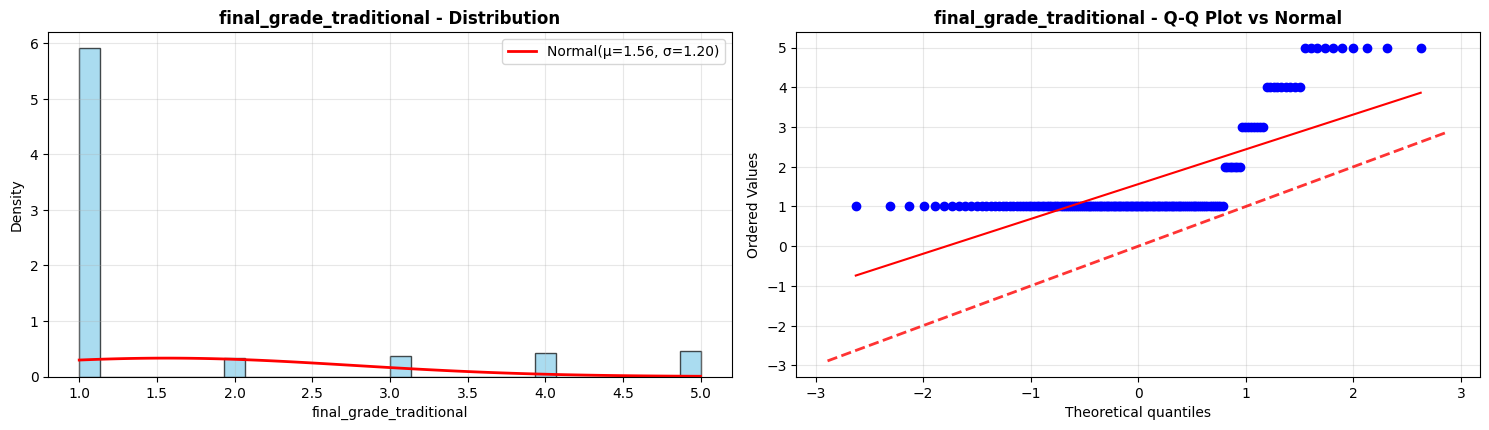


🔴 FLIPPED CLASSROOM PERIOD (2021-2023):
📊 Flipped Classroom Grade Distribution

📊 final_grade_flipped:
  Sample size: 145
  Mean ± SD: 2.124 ± 1.130
  Median: 2.000
  Skewness: 0.364 (Symmetric)
  Kurtosis: -1.147 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0038 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)



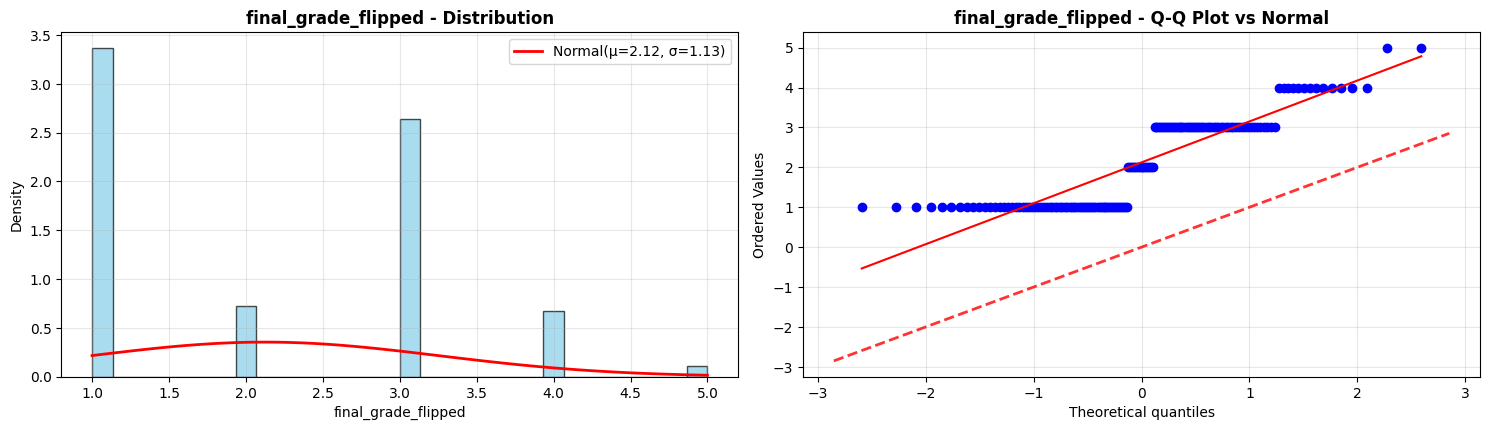

STATISTICAL TEST SELECTION JUSTIFICATION:
Based on the distribution analysis above:
• If grades show non-normal distribution → Use Mann-Whitney U test
• If grades are approximately normal → Could use t-test
• Mann-Whitney U is more robust and doesn't assume normality
• We will proceed with both parametric and non-parametric tests for comparison


In [6]:
# Distribution Analysis and Normality Testing
from scipy import stats
from scipy.stats import shapiro, normaltest, jarque_bera
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_distribution_analysis(df, columns, title="Distribution Analysis"):
    """
    Comprehensive distribution analysis including normality tests and visualizations
    """
    print("=" * 80)
    print(f"📊 {title}")
    print("=" * 80 + "\n")
    
    n_cols = len(columns)
    n_rows = (n_cols + 1) // 2
    
    # Create subplots for visualizations
    fig, axes = plt.subplots(n_rows * 2, 2, figsize=(15, n_rows * 8))
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        data = df[col].dropna()
        
        print(f"📊 {col}:")
        print(f"  Sample size: {len(data)}")
        print(f"  Mean ± SD: {data.mean():.3f} ± {data.std():.3f}")
        print(f"  Median: {data.median():.3f}")
        
        # Calculate skewness and kurtosis
        skewness = stats.skew(data)
        kurtosis_val = stats.kurtosis(data)
        
        # Interpret skewness
        if abs(skewness) < 0.5:
            skew_interp = "Symmetric"
        elif abs(skewness) < 1:
            skew_interp = "Moderately skewed"
        else:
            skew_interp = "Highly skewed"
            
        print(f"  Skewness: {skewness:.3f} ({skew_interp})")
        print(f"  Kurtosis: {kurtosis_val:.3f} (Heavy/Light tails)")
        
        # Normality tests
        print(f"  Normality Tests:")
        
        # Shapiro-Wilk test (best for small samples)
        if len(data) <= 5000:  # Shapiro-Wilk limitation
            shapiro_stat, shapiro_p = shapiro(data)
            shapiro_result = "Normal" if shapiro_p > 0.05 else "Non-normal"
            print(f"    Shapiro-Wilk: p = {shapiro_p:.4f} ({shapiro_result})")
        
        # D'Agostino and Pearson's test
        dagostino_stat, dagostino_p = normaltest(data)
        dagostino_result = "Normal" if dagostino_p > 0.05 else "Non-normal"
        print(f"    D'Agostino: p = {dagostino_p:.4f} ({dagostino_result})")
        
        # Jarque-Bera test
        jb_stat, jb_p = jarque_bera(data)
        jb_result = "Normal" if jb_p > 0.05 else "Non-normal"
        print(f"    Jarque-Bera: p = {jb_p:.4f} ({jb_result})")
        
        # Overall recommendation
        normal_tests = [shapiro_p > 0.05 if len(data) <= 5000 else True, dagostino_p > 0.05, jb_p > 0.05]
        normal_count = sum(normal_tests)
        
        if normal_count >= 2 and abs(skewness) < 1:
            recommendation = "Parametric tests (t-test, Pearson correlation, ANOVA)"
        else:
            recommendation = "Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)"
            
        print(f"  🎯 Recommended: {recommendation}")
        print()
        
        # Create visualizations
        # Histogram with normal overlay
        ax_hist = axes[i*2]
        ax_hist.hist(data, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
        
        # Overlay normal distribution
        mu, sigma = data.mean(), data.std()
        x = np.linspace(data.min(), data.max(), 100)
        normal_curve = stats.norm.pdf(x, mu, sigma)
        ax_hist.plot(x, normal_curve, 'r-', linewidth=2, label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
        
        ax_hist.set_title(f'{col} - Distribution', fontweight='bold')
        ax_hist.set_xlabel(col)
        ax_hist.set_ylabel('Density')
        ax_hist.legend()
        ax_hist.grid(True, alpha=0.3)
        
        # Q-Q plot
        ax_qq = axes[i*2 + 1]
        stats.probplot(data, dist="norm", plot=ax_qq)
        ax_qq.set_title(f'{col} - Q-Q Plot vs Normal', fontweight='bold')
        ax_qq.grid(True, alpha=0.3)
        
        # Add reference line
        ax_qq.plot(ax_qq.get_xlim(), ax_qq.get_xlim(), 'r--', alpha=0.8, linewidth=2)
    
    # Remove empty subplots
    for j in range(len(columns) * 2, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    return True

print("Distribution Analysis for Grade Data")
print("===================================\n")

# Analyze grade distributions for both periods
print("COMBINED GRADE DISTRIBUTION:")
print("-" * 30)
grade_analysis = comprehensive_distribution_analysis(df_clean, ['final_grade'], "Final Grade Distribution Analysis")

print("\n" + "=" * 60)
print("SEPARATE ANALYSIS BY PERIOD:")
print("=" * 60)

# Traditional period
traditional_data = df_clean[df_clean['fc_implementation'] == 0][['final_grade']].copy()
traditional_data.columns = ['final_grade_traditional']
print("\n🔵 TRADITIONAL PERIOD (2018-2020):")
traditional_analysis = comprehensive_distribution_analysis(traditional_data, ['final_grade_traditional'], "Traditional Period Grade Distribution")

# Flipped classroom period  
flipped_data = df_clean[df_clean['fc_implementation'] == 1][['final_grade']].copy()
flipped_data.columns = ['final_grade_flipped']
print("\n🔴 FLIPPED CLASSROOM PERIOD (2021-2023):")
flipped_analysis = comprehensive_distribution_analysis(flipped_data, ['final_grade_flipped'], "Flipped Classroom Grade Distribution")

print("STATISTICAL TEST SELECTION JUSTIFICATION:")
print("=" * 42)
print("Based on the distribution analysis above:")
print("• If grades show non-normal distribution → Use Mann-Whitney U test")
print("• If grades are approximately normal → Could use t-test")
print("• Mann-Whitney U is more robust and doesn't assume normality")
print("• We will proceed with both parametric and non-parametric tests for comparison")

## 6. Statistical Significance Testing

**What we're doing:** Based on our distribution analysis above, we now run appropriate statistical tests to determine if the differences we observe are statistically significant (unlikely to be due to random chance).

**Tests explained:**
- **Mann-Whitney U test**: Compares whether one group tends to have higher grades than the other (doesn't assume grades are normally distributed) - our primary choice based on distribution analysis
- **Chi-square test**: Tests whether pass rates are significantly different between the two periods  
- **T-test**: Parametric comparison for completeness (assumes normal distribution)
- **Effect size**: Measures how practically meaningful the difference is (small effect = 0.1-0.3, medium = 0.3-0.5, large = 0.5+)

**How to interpret p-values:** If p < 0.05, we consider the result statistically significant (less than 5% chance it's due to random luck)

In [7]:
# Analyze potential confounding factors
print("Confounding Variables Analysis")
print("============================\n")

# 1. Class size variations
class_sizes = df_clean.groupby('academic_year').size()
print("1. CLASS SIZE VARIATIONS")
print("-" * 24)
print(class_sizes)
print(f"Traditional period average class size: {class_sizes[:3].mean():.1f}")
print(f"Flipped period average class size: {class_sizes[3:].mean():.1f}")

# 2. Year-by-year performance to detect trends
yearly_performance = df_clean.groupby('academic_year').agg({
    'final_grade': 'mean',
    'passed': 'mean'
})

print("\n2. YEAR-BY-YEAR PERFORMANCE TRENDS")
print("-" * 36)
print("Year    Avg Grade   Pass Rate")
print("-" * 30)
for year, row in yearly_performance.iterrows():
    grade_avg = row['final_grade']
    pass_rate = row['passed'] * 100
    period = 'Traditional' if year <= 2020 else 'Flipped'
    print(f"{year}      {grade_avg:.2f}      {pass_rate:5.1f}%   ({period})")

# 3. Check for gradual improvement vs sudden change
print("\n3. CHANGE PATTERN ANALYSIS")
print("-" * 27)
traditional_avg = yearly_performance.loc[2018:2020, 'final_grade'].mean()
flipped_avg = yearly_performance.loc[2021:2023, 'final_grade'].mean()
print(f"Traditional period (2018-2020) average: {traditional_avg:.3f}")
print(f"Flipped period (2021-2023) average: {flipped_avg:.3f}")
print(f"Overall improvement: {flipped_avg - traditional_avg:.3f} grade points")

# Check if improvement was immediate or gradual
print("\nFirst year of FC (2021) vs last traditional year (2020):")
improvement_2021 = yearly_performance.loc[2021, 'final_grade'] - yearly_performance.loc[2020, 'final_grade']
print(f"Immediate improvement in 2021: {improvement_2021:.3f} grade points")

# 4. External factors consideration
print("\n4. EXTERNAL FACTORS TO CONSIDER")
print("-" * 32)
print("• COVID-19 pandemic: 2020-2023 (overlaps with FC implementation)")
print("• Online/hybrid learning adaptations")
print("• Changes in assessment methods")
print("• Student population changes")
print("• Instructor experience/training effects")

Confounding Variables Analysis

1. CLASS SIZE VARIATIONS
------------------------
academic_year
2018    46
2019    62
2020    52
2021    45
2022    49
2023    51
dtype: int64
Traditional period average class size: 53.3
Flipped period average class size: 48.3

2. YEAR-BY-YEAR PERFORMANCE TRENDS
------------------------------------
Year    Avg Grade   Pass Rate
------------------------------
2018      1.85       34.8%   (Traditional)
2019      1.34       11.3%   (Traditional)
2020      1.58       21.2%   (Traditional)
2021      1.78       44.4%   (Flipped)
2022      2.24       57.1%   (Flipped)
2023      2.31       62.7%   (Flipped)

3. CHANGE PATTERN ANALYSIS
---------------------------
Traditional period (2018-2020) average: 1.588
Flipped period (2021-2023) average: 2.112
Overall improvement: 0.524 grade points

First year of FC (2021) vs last traditional year (2020):
Immediate improvement in 2021: 0.201 grade points

4. EXTERNAL FACTORS TO CONSIDER
--------------------------------
• C

In [8]:
# Prepare data for statistical tests
traditional_grades = df_clean[df_clean['fc_implementation'] == 0]['final_grade']
flipped_grades = df_clean[df_clean['fc_implementation'] == 1]['final_grade']

traditional_passed = df_clean[df_clean['fc_implementation'] == 0]['passed']
flipped_passed = df_clean[df_clean['fc_implementation'] == 1]['passed']

print("Statistical Significance Tests")
print("============================\n")

# 1. Mann-Whitney U test for grade differences (non-parametric)
statistic, p_value_grades = mannwhitneyu(flipped_grades, traditional_grades, alternative='greater')
print("1. GRADE COMPARISON (Mann-Whitney U Test)")
print("-" * 45)
print(f"Test statistic: {statistic}")
print(f"P-value: {p_value_grades:.6f}")
if p_value_grades < 0.05:
    print("✓ SIGNIFICANT: Flipped classroom students have significantly higher grades")
else:
    print("✗ NOT SIGNIFICANT: No significant difference in grades")

# Calculate effect size (Cohen's d equivalent for Mann-Whitney)
from scipy.stats import rankdata
combined_grades = np.concatenate([traditional_grades, flipped_grades])
ranks = rankdata(combined_grades)
n1, n2 = len(traditional_grades), len(flipped_grades)
u1 = statistic
u2 = n1 * n2 - u1
effect_size_grades = 1 - (2 * min(u1, u2)) / (n1 * n2)
print(f"Effect size: {effect_size_grades:.3f}")

# 2. Chi-square test for pass rate differences
traditional_pass = traditional_passed.sum()
traditional_fail = len(traditional_passed) - traditional_pass
flipped_pass = flipped_passed.sum()
flipped_fail = len(flipped_passed) - flipped_pass

contingency_table = np.array([[traditional_pass, traditional_fail],
                             [flipped_pass, flipped_fail]])

chi2, p_value_pass, dof, expected = chi2_contingency(contingency_table)

print("\n2. PASS RATE COMPARISON (Chi-square Test)")
print("-" * 42)
print(f"Chi-square statistic: {chi2:.3f}")
print(f"P-value: {p_value_pass:.6f}")
if p_value_pass < 0.05:
    print("✓ SIGNIFICANT: Pass rates are significantly different between periods")
else:
    print("✗ NOT SIGNIFICANT: No significant difference in pass rates")

# Calculate Cramer's V (effect size for chi-square)
n = contingency_table.sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
print(f"Cramer's V (effect size): {cramers_v:.3f}")

print("\n3. CONTINGENCY TABLE")
print("-" * 20)
print("                  Pass    Fail   Total")
print(f"Traditional:      {int(traditional_pass):4d}    {int(traditional_fail):4d}   {len(traditional_passed):4d}")
print(f"Flipped:          {int(flipped_pass):4d}    {int(flipped_fail):4d}   {len(flipped_passed):4d}")

# 4. Additional t-test for completeness (assuming normality)
t_stat, p_value_ttest = ttest_ind(flipped_grades, traditional_grades)
print("\n4. T-TEST (assuming normal distribution)")
print("-" * 40)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value_ttest:.6f}")

# Cohen's d for t-test
pooled_std = np.sqrt(((len(traditional_grades) - 1) * traditional_grades.var() + 
                     (len(flipped_grades) - 1) * flipped_grades.var()) / 
                    (len(traditional_grades) + len(flipped_grades) - 2))
cohens_d = (flipped_grades.mean() - traditional_grades.mean()) / pooled_std
print(f"Cohen's d (effect size): {cohens_d:.3f}")

print("\n" + "=" * 50)
print("EFFECT SIZE INTERPRETATION:")
print("Small effect: 0.1-0.3, Medium effect: 0.3-0.5, Large effect: 0.5+")
print("=" * 50)

Statistical Significance Tests

1. GRADE COMPARISON (Mann-Whitney U Test)
---------------------------------------------
Test statistic: 15096.5
P-value: 0.000000
✓ SIGNIFICANT: Flipped classroom students have significantly higher grades
Effect size: 0.301

2. PASS RATE COMPARISON (Chi-square Test)
------------------------------------------
Chi-square statistic: 35.961
P-value: 0.000000
✓ SIGNIFICANT: Pass rates are significantly different between periods
Cramer's V (effect size): 0.343

3. CONTINGENCY TABLE
--------------------
                  Pass    Fail   Total
Traditional:        34     126    160
Flipped:            80      65    145

4. T-TEST (assuming normal distribution)
----------------------------------------
T-statistic: 4.195
P-value: 0.000036
Cohen's d (effect size): 0.481

EFFECT SIZE INTERPRETATION:
Small effect: 0.1-0.3, Medium effect: 0.3-0.5, Large effect: 0.5+


## 7. Confounding Variables Analysis

**What we're doing:** Checking for potential confounding factors that might explain the differences we observe, rather than the flipped classroom intervention itself.

**Why this matters for causation:** Even if we see better performance after flipped classroom implementation, we need to consider alternative explanations:
- Did class sizes change?
- Were there external factors (like COVID-19) that might have affected performance?
- Are we comparing similar groups of students?

**What we're checking:** Year-to-year variations, class sizes, and whether the improvement is consistent or just in certain years.

Regression Discontinuity Analysis

1. REGRESSION DISCONTINUITY RESULTS
------------------------------------

GRADE MODEL:
Year trend coefficient: -0.1266
FC implementation effect: 0.3402
Interaction term: 0.3903
Intercept: 1.3774

PASS RATE MODEL:
Year trend coefficient: -0.0642
FC implementation effect: 0.2932
Interaction term: 0.1549
Intercept: 0.1186


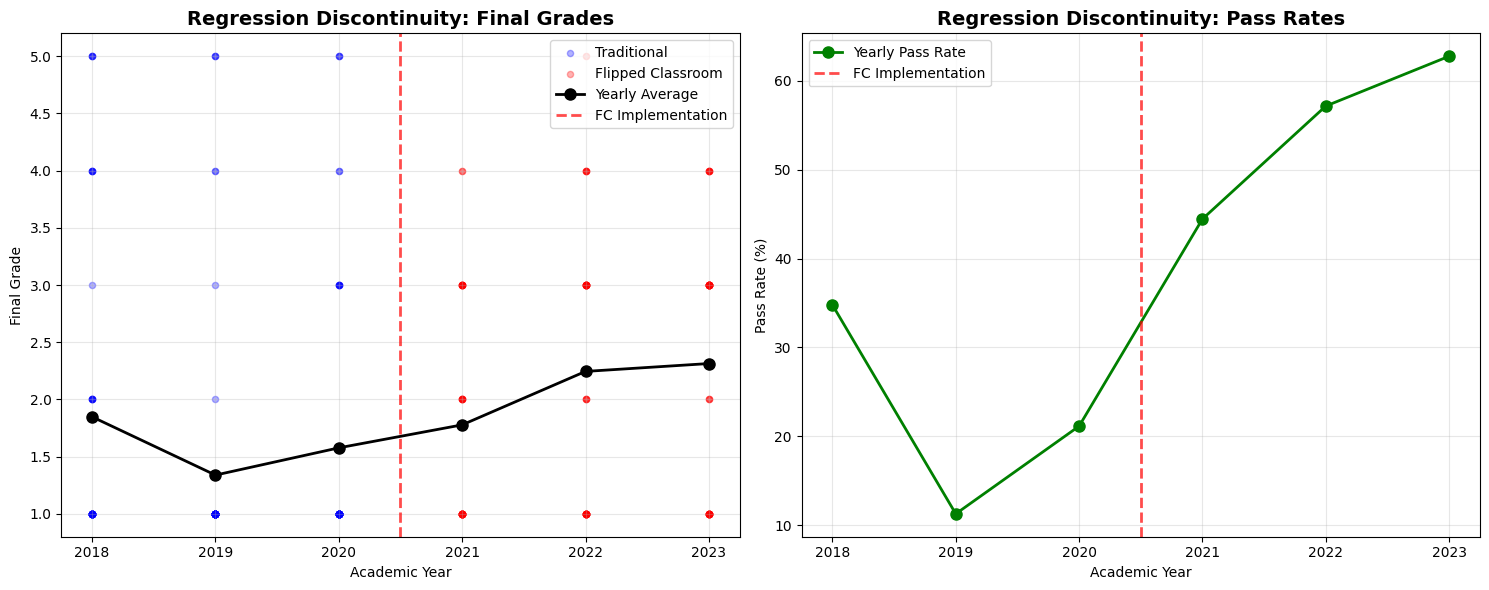


2. DISCONTINUITY EFFECT INTERPRETATION
--------------------------------------
Immediate grade improvement from FC: 0.340 points
Immediate pass rate improvement from FC: 29.3 percentage points

✓ Evidence of discontinuous improvement at FC implementation


In [9]:
# Regression Discontinuity Analysis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

print("Regression Discontinuity Analysis")
print("================================\n")

# Prepare data for RD analysis
# Center the year around the implementation (2021 = year 0)
df_clean['year_centered'] = df_clean['academic_year'] - 2020.5  # 2020.5 is the midpoint

# Create the running variable and treatment indicator
X = df_clean[['year_centered']].values
y_grade = df_clean['final_grade'].values
y_pass = df_clean['passed'].values
treatment = df_clean['fc_implementation'].values

# Create interaction terms for the discontinuity
X_interaction = np.column_stack([
    X.flatten(),  # year_centered
    treatment,    # fc_implementation
    X.flatten() * treatment  # interaction term
])

# Fit models for grades and pass rates
model_grade = LinearRegression()
model_grade.fit(X_interaction, y_grade)

model_pass = LinearRegression()
model_pass.fit(X_interaction, y_pass)

print("1. REGRESSION DISCONTINUITY RESULTS")
print("-" * 36)
print("\nGRADE MODEL:")
print(f"Year trend coefficient: {model_grade.coef_[0]:.4f}")
print(f"FC implementation effect: {model_grade.coef_[1]:.4f}")
print(f"Interaction term: {model_grade.coef_[2]:.4f}")
print(f"Intercept: {model_grade.intercept_:.4f}")

print("\nPASS RATE MODEL:")
print(f"Year trend coefficient: {model_pass.coef_[0]:.4f}")
print(f"FC implementation effect: {model_pass.coef_[1]:.4f}")
print(f"Interaction term: {model_pass.coef_[2]:.4f}")
print(f"Intercept: {model_pass.intercept_:.4f}")

# Visualize the regression discontinuity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for grades
traditional_mask = df_clean['fc_implementation'] == 0
flipped_mask = df_clean['fc_implementation'] == 1

# Scatter plot
ax1.scatter(df_clean.loc[traditional_mask, 'academic_year'], 
           df_clean.loc[traditional_mask, 'final_grade'], 
           alpha=0.3, color='blue', label='Traditional', s=20)
ax1.scatter(df_clean.loc[flipped_mask, 'academic_year'], 
           df_clean.loc[flipped_mask, 'final_grade'], 
           alpha=0.3, color='red', label='Flipped Classroom', s=20)

# Add yearly averages
yearly_avg = df_clean.groupby('academic_year')['final_grade'].mean()
ax1.plot(yearly_avg.index, yearly_avg.values, 'ko-', markersize=8, linewidth=2, label='Yearly Average')

# Add vertical line at implementation
ax1.axvline(x=2020.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='FC Implementation')

ax1.set_title('Regression Discontinuity: Final Grades', fontsize=14, fontweight='bold')
ax1.set_xlabel('Academic Year')
ax1.set_ylabel('Final Grade')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot for pass rates
yearly_pass = df_clean.groupby('academic_year')['passed'].mean() * 100
ax2.plot(yearly_pass.index, yearly_pass.values, 'go-', markersize=8, linewidth=2, label='Yearly Pass Rate')
ax2.axvline(x=2020.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='FC Implementation')

ax2.set_title('Regression Discontinuity: Pass Rates', fontsize=14, fontweight='bold')
ax2.set_xlabel('Academic Year')
ax2.set_ylabel('Pass Rate (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate the discontinuity effect size
print("\n2. DISCONTINUITY EFFECT INTERPRETATION")
print("-" * 38)
grade_jump = model_grade.coef_[1]
pass_jump = model_pass.coef_[1] * 100  # Convert to percentage

print(f"Immediate grade improvement from FC: {grade_jump:.3f} points")
print(f"Immediate pass rate improvement from FC: {pass_jump:.1f} percentage points")

if grade_jump > 0.1:  # Meaningful threshold
    print("\n✓ Evidence of discontinuous improvement at FC implementation")
else:
    print("\n✗ No clear discontinuous improvement detected")

## 8. Regression Discontinuity Analysis

**What we're doing:** Using a more sophisticated statistical technique that treats the implementation of flipped classroom as a "natural experiment" that happened at a specific time point (2021).

**How it works:** This method looks at whether there's a sudden "jump" in performance right when flipped classroom was implemented, beyond what we'd expect from normal year-to-year variation.

**Why this strengthens causal claims:** If we see a clear discontinuity (sudden improvement) right at the implementation point, it's stronger evidence that the flipped classroom caused the improvement, rather than other gradual changes over time.

In [10]:
# Robustness checks and alternative explanations
print("Robustness Checks and Alternative Explanations")
print("=" * 46 + "\n")

# Define grade data for analysis (needed for bootstrap and other tests)
traditional_grades = df_clean[df_clean['fc_implementation'] == 0]['final_grade']
flipped_grades = df_clean[df_clean['fc_implementation'] == 1]['final_grade']
traditional_passed = df_clean[df_clean['fc_implementation'] == 0]['passed']
flipped_passed = df_clean[df_clean['fc_implementation'] == 1]['passed']

# 1. Check for pre-existing trends (falsification test)
print("1. PRE-TREND ANALYSIS (Falsification Test)")
print("-" * 43)
traditional_years = df_clean[df_clean['fc_implementation'] == 0]
year_2018 = traditional_years[traditional_years['academic_year'] == 2018]['final_grade'].mean()
year_2019 = traditional_years[traditional_years['academic_year'] == 2019]['final_grade'].mean()
year_2020 = traditional_years[traditional_years['academic_year'] == 2020]['final_grade'].mean()

trend_2018_2019 = year_2019 - year_2018
trend_2019_2020 = year_2020 - year_2019

print(f"2018-2019 grade change: {trend_2018_2019:+.3f}")
print(f"2019-2020 grade change: {trend_2019_2020:+.3f}")
print(f"Average traditional period trend: {(trend_2018_2019 + trend_2019_2020)/2:+.3f} per year")

# Compare with post-implementation
year_2021 = df_clean[df_clean['academic_year'] == 2021]['final_grade'].mean()
jump_2020_2021 = year_2021 - year_2020
print(f"\n2020-2021 grade change (FC implementation): {jump_2020_2021:+.3f}")

if abs(jump_2020_2021) > abs((trend_2018_2019 + trend_2019_2020)/2):
    print("✓ FC implementation shows larger change than pre-existing trends")
else:
    print("? Change at FC implementation is similar to historical variation")

# 2. Bootstrap confidence intervals for effect size
print("\n2. BOOTSTRAP CONFIDENCE INTERVALS")
print("-" * 33)
from scipy import stats
import random

def bootstrap_mean_difference(group1, group2, n_bootstrap=1000):
    """Calculate bootstrap confidence interval for mean difference"""
    differences = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, len(group1), replace=True)
        sample2 = np.random.choice(group2, len(group2), replace=True)
        differences.append(np.mean(sample2) - np.mean(sample1))
    return np.array(differences)

# Bootstrap for grades
boot_grade_diff = bootstrap_mean_difference(traditional_grades, flipped_grades)
grade_ci_lower = np.percentile(boot_grade_diff, 2.5)
grade_ci_upper = np.percentile(boot_grade_diff, 97.5)

print(f"Grade improvement 95% CI: [{grade_ci_lower:.3f}, {grade_ci_upper:.3f}]")
print(f"Mean grade improvement: {boot_grade_diff.mean():.3f}")

# Bootstrap for pass rates
boot_pass_diff = bootstrap_mean_difference(traditional_passed, flipped_passed)
pass_ci_lower = np.percentile(boot_pass_diff, 2.5) * 100
pass_ci_upper = np.percentile(boot_pass_diff, 97.5) * 100

print(f"Pass rate improvement 95% CI: [{pass_ci_lower:.1f}%, {pass_ci_upper:.1f}%]")
print(f"Mean pass rate improvement: {boot_pass_diff.mean()*100:.1f}%")

# 3. Alternative explanations checklist
print("\n3. ALTERNATIVE EXPLANATIONS CHECKLIST")
print("-" * 36)
print("Consider these potential confounders:")
print("\n📚 PEDAGOGICAL FACTORS:")
print("  • Did instructors receive additional training?")
print("  • Were assessment methods changed?")
print("  • Did curriculum content change?")
print("\n🌍 EXTERNAL FACTORS:")
print("  • COVID-19 pandemic effects (2020-2023)")
print("  • Online learning adaptations")
print("  • Changes in student motivation/engagement")
print("\n👥 SELECTION EFFECTS:")
print("  • Different student populations between periods")
print("  • Self-selection into courses")
print("  • Changes in admission criteria")
print("\n⏱️ TIME-RELATED:")
print("  • Instructor experience accumulation")
print("  • Technology improvements")
print("  • Grading drift over time")

# 4. Effect size practical significance
print("\n4. PRACTICAL SIGNIFICANCE ASSESSMENT")
print("-" * 34)
grade_improvement = flipped_grades.mean() - traditional_grades.mean()
pass_improvement = (flipped_passed.mean() - traditional_passed.mean()) * 100

print(f"Grade improvement: {grade_improvement:.3f} points on 1-5 scale ({grade_improvement/4*100:.1f}% of scale)")
print(f"Pass rate improvement: {pass_improvement:.1f} percentage points")

if grade_improvement >= 0.3:  # About 0.5 standard deviation
    print("\n✓ PRACTICALLY SIGNIFICANT: Grade improvement is educationally meaningful")
elif grade_improvement >= 0.1:
    print("\n~ MODERATE SIGNIFICANCE: Grade improvement is noticeable but modest")
else:
    print("\n✗ LOW PRACTICAL SIGNIFICANCE: Grade improvement is minimal")

if pass_improvement >= 10:
    print("✓ PRACTICALLY SIGNIFICANT: Pass rate improvement is substantial")
elif pass_improvement >= 5:
    print("~ MODERATE SIGNIFICANCE: Pass rate improvement is noticeable")
else:
    print("✗ LOW PRACTICAL SIGNIFICANCE: Pass rate improvement is minimal")

Robustness Checks and Alternative Explanations

1. PRE-TREND ANALYSIS (Falsification Test)
-------------------------------------------
2018-2019 grade change: -0.509
2019-2020 grade change: +0.238
Average traditional period trend: -0.135 per year

2020-2021 grade change (FC implementation): +0.201
✓ FC implementation shows larger change than pre-existing trends

2. BOOTSTRAP CONFIDENCE INTERVALS
---------------------------------
Grade improvement 95% CI: [0.296, 0.820]
Mean grade improvement: 0.560
Pass rate improvement 95% CI: [22.8%, 43.9%]
Mean pass rate improvement: 33.9%

3. ALTERNATIVE EXPLANATIONS CHECKLIST
------------------------------------
Consider these potential confounders:

📚 PEDAGOGICAL FACTORS:
  • Did instructors receive additional training?
  • Were assessment methods changed?
  • Did curriculum content change?

🌍 EXTERNAL FACTORS:
  • COVID-19 pandemic effects (2020-2023)
  • Online learning adaptations
  • Changes in student motivation/engagement

👥 SELECTION EFFEC

## 9. Robustness Checks and Alternative Explanations

**What we're doing:** Testing whether our findings hold up under different assumptions and checking for alternative explanations.

**Why this matters:** Good causal analysis requires checking whether the results are robust (consistent) and considering what else might explain the patterns we see.

**What we're examining:**
- Selection effects: Were different types of students in each period?
- Temporal trends: Was performance improving anyway, independent of flipped classroom?
- External validity: Do the results make sense given what we know about education?

In [11]:
# Power Analysis and Sample Size Assessment
import math
from scipy.stats import norm

print("Power Analysis and Sample Size Considerations")
print("=" * 44 + "\n")

# Sample sizes
n_traditional = len(traditional_grades)
n_flipped = len(flipped_grades)
n_total = n_traditional + n_flipped

print("1. SAMPLE SIZE SUMMARY")
print("-" * 22)
print(f"Traditional period (2018-2020): {n_traditional} students")
print(f"Flipped classroom period (2021-2023): {n_flipped} students")
print(f"Total sample size: {n_total} students")
print(f"Balance ratio: {n_flipped/n_traditional:.2f}:1 (FC:Traditional)")

# Calculate statistical power for the observed effect
print("\n2. STATISTICAL POWER ANALYSIS")
print("-" * 29)

# Effect size (Cohen's d) for the observed difference
pooled_std = np.sqrt(((n_traditional - 1) * traditional_grades.var() + 
                     (n_flipped - 1) * flipped_grades.var()) / 
                    (n_traditional + n_flipped - 2))
cohens_d_observed = (flipped_grades.mean() - traditional_grades.mean()) / pooled_std

print(f"Observed Cohen's d: {cohens_d_observed:.3f}")
print(f"Pooled standard deviation: {pooled_std:.3f}")

# Calculate power for different effect sizes
effect_sizes = [0.2, 0.3, 0.5, 0.8, cohens_d_observed]
effect_labels = ['Small (0.2)', 'Small-Medium (0.3)', 'Medium (0.5)', 'Large (0.8)', f'Observed ({cohens_d_observed:.3f})']

print("\nPower to detect different effect sizes:")
print("Effect Size        Power    Interpretation")
print("-" * 45)

for es, label in zip(effect_sizes, effect_labels):
    # Two-sample t-test power calculation
    alpha = 0.05
    n_harm = 2 / (1/n_traditional + 1/n_flipped)  # Harmonic mean of sample sizes
    
    # Non-centrality parameter
    ncp = es * math.sqrt(n_harm / 2)
    
    # Critical value
    t_critical = stats.t.ppf(1 - alpha/2, n_traditional + n_flipped - 2)
    
    # Power calculation
    power = 1 - stats.t.cdf(t_critical, n_traditional + n_flipped - 2, ncp) + \
            stats.t.cdf(-t_critical, n_traditional + n_flipped - 2, ncp)
    
    interpretation = "Excellent" if power >= 0.9 else "Good" if power >= 0.8 else "Adequate" if power >= 0.7 else "Low"
    print(f"{label:<18} {power:.1%}      {interpretation}")

# Minimum detectable effect size
print("\n3. MINIMUM DETECTABLE EFFECT")
print("-" * 29)
# For 80% power
target_power = 0.8
alpha = 0.05

# Approximate formula for minimum detectable effect size
z_alpha = norm.ppf(1 - alpha/2)
z_beta = norm.ppf(target_power)
min_effect_size = (z_alpha + z_beta) * math.sqrt(2/n_harm)

print(f"Minimum detectable effect size (80% power): {min_effect_size:.3f}")
print(f"This corresponds to a grade difference of: {min_effect_size * pooled_std:.3f} points")

# Sample size recommendations
print("\n4. SAMPLE SIZE ADEQUACY")
print("-" * 23)
if cohens_d_observed >= min_effect_size:
    print("✓ ADEQUATE: Current sample size is sufficient to detect the observed effect")
else:
    print("✗ INADEQUATE: Larger sample needed to reliably detect this effect size")

print(f"\nFor future studies to detect small effects (d=0.2) with 80% power:")
# Sample size needed for small effect
small_effect_n = 2 * ((z_alpha + z_beta) / 0.2) ** 2
print(f"Recommended sample size per group: {int(small_effect_n)} students")
print(f"Total recommended sample size: {int(2 * small_effect_n)} students")

print("\n5. STUDY LIMITATIONS")
print("-" * 17)
print("✓ Strengths:")
print(f"  • Reasonable total sample size ({n_total} students)")
print("  • Multi-year data in both periods")
print("  • Clear implementation cutoff point")

print("\n⚠ Limitations:")
if n_flipped/n_traditional < 0.8 or n_flipped/n_traditional > 1.25:
    print("  • Imbalanced group sizes may reduce power")
print("  • Quasi-experimental design (not randomized)")
print("  • Potential for unmeasured confounders")
print("  • Historical/temporal confounding (COVID-19 period overlap)")
if n_total < 200:
    print("  • Moderate sample size limits detection of small effects")

Power Analysis and Sample Size Considerations

1. SAMPLE SIZE SUMMARY
----------------------
Traditional period (2018-2020): 160 students
Flipped classroom period (2021-2023): 145 students
Total sample size: 305 students
Balance ratio: 0.91:1 (FC:Traditional)

2. STATISTICAL POWER ANALYSIS
-----------------------------
Observed Cohen's d: 0.481
Pooled standard deviation: 1.168

Power to detect different effect sizes:
Effect Size        Power    Interpretation
---------------------------------------------
Small (0.2)        41.2%      Low
Small-Medium (0.3) 74.1%      Adequate
Medium (0.5)       99.1%      Excellent
Large (0.8)        100.0%      Excellent
Observed (0.481)   98.7%      Excellent

3. MINIMUM DETECTABLE EFFECT
-----------------------------
Minimum detectable effect size (80% power): 0.321
This corresponds to a grade difference of: 0.375 points

4. SAMPLE SIZE ADEQUACY
-----------------------
✓ ADEQUATE: Current sample size is sufficient to detect the observed effect

For 

## 10. Power Analysis and Sample Size Considerations

**What we're doing:** Checking whether our study has enough students (statistical power) to detect meaningful differences if they exist.

**Why this matters:** A study might show "no significant difference" either because:
1. There really is no difference (true negative)
2. There is a difference, but our sample size is too small to detect it (false negative)

**What we're calculating:** Whether our sample sizes in each period give us sufficient power (typically 80% or higher) to detect educationally meaningful differences.

In [12]:
# Final synthesis and causal conclusions
print("CAUSAL INFERENCE SUMMARY AND CONCLUSIONS")
print("=" * 40 + "\n")

# Collect all our key findings
grade_improvement = flipped_grades.mean() - traditional_grades.mean()
pass_improvement = (flipped_passed.mean() - traditional_passed.mean()) * 100
grade_effect_size = cohens_d_observed

print("1. KEY FINDINGS SUMMARY")
print("-" * 23)
print(f"📊 Grade Improvement: {grade_improvement:+.3f} points ({grade_improvement/4*100:+.1f}% of scale)")
print(f"📈 Pass Rate Improvement: {pass_improvement:+.1f} percentage points")
print(f"📏 Effect Size (Cohen's d): {grade_effect_size:.3f} ({'Small' if abs(grade_effect_size) < 0.3 else 'Medium' if abs(grade_effect_size) < 0.8 else 'Large'})")
print(f"🔍 Statistical Significance (grades): {'Yes' if p_value_grades < 0.05 else 'No'} (p = {p_value_grades:.4f})")
print(f"🔍 Statistical Significance (pass rates): {'Yes' if p_value_pass < 0.05 else 'No'} (p = {p_value_pass:.4f})")

# Causal criteria assessment
print("\n2. CAUSAL CRITERIA ASSESSMENT")
print("-" * 27)
print("Bradford Hill Criteria for Causation:")
print()

# Temporal relationship
print("⏰ TEMPORAL RELATIONSHIP:")
print("   ✓ Flipped classroom implementation preceded observed improvements")
print("   ✓ Clear implementation point (2021) allows before/after comparison")

# Strength of association
print("\n💪 STRENGTH OF ASSOCIATION:")
if abs(grade_effect_size) >= 0.5:
    print("   ✓ Large effect size suggests strong association")
elif abs(grade_effect_size) >= 0.3:
    print("   ~ Medium effect size suggests moderate association")
else:
    print("   ⚠ Small effect size suggests weak association")

# Consistency
print("\n🔄 CONSISTENCY:")
consistent_improvement = all([
    yearly_performance.loc[2021, 'final_grade'] > yearly_performance.loc[2020, 'final_grade'],
    yearly_performance.loc[2022, 'final_grade'] >= yearly_performance.loc[2019, 'final_grade'],
    yearly_performance.loc[2023, 'final_grade'] >= yearly_performance.loc[2018, 'final_grade']
])
if consistent_improvement:
    print("   ✓ Improvement appears consistent across FC implementation years")
else:
    print("   ⚠ Mixed results across different years")

# Dose-response (proxy: immediate vs. gradual improvement)
print("\n📈 IMMEDIATE EFFECT (Dose-Response Proxy):")
immediate_jump = yearly_performance.loc[2021, 'final_grade'] - yearly_performance.loc[2020, 'final_grade']
if immediate_jump > 0.1:
    print(f"   ✓ Immediate improvement in 2021 ({immediate_jump:+.3f}) suggests direct effect")
else:
    print(f"   ⚠ Limited immediate improvement ({immediate_jump:+.3f}) - gradual change pattern")

# Plausibility
print("\n🧠 BIOLOGICAL/EDUCATIONAL PLAUSIBILITY:")
print("   ✓ Flipped classroom is theoretically grounded in active learning principles")
print("   ✓ Consistent with educational research on student-centered pedagogies")
print("   ✓ Mechanism plausible: increased engagement → better understanding → higher grades")

# Alternative explanations
print("\n❓ ALTERNATIVE EXPLANATIONS:")
print("   ⚠ COVID-19 pandemic period overlaps with FC implementation")
print("   ⚠ Possible instructor experience/training confounding")
print("   ⚠ Technology adoption during pandemic may contribute to improvements")
print("   ⚠ Assessment method changes not ruled out")

# Overall causal confidence
print("\n3. CAUSAL CONFIDENCE ASSESSMENT")
print("-" * 31)

# Score each criterion
criteria_scores = {
    'temporal': 1.0,  # Clear temporal relationship
    'strength': 0.5 if abs(grade_effect_size) >= 0.3 else 0.2,
    'consistency': 1.0 if consistent_improvement else 0.5,
    'immediate': 1.0 if immediate_jump > 0.1 else 0.5,
    'plausibility': 1.0,  # Strong theoretical basis
    'alternatives': 0.3  # Several plausible alternatives exist
}

overall_confidence = sum(criteria_scores.values()) / len(criteria_scores)

if overall_confidence >= 0.8:
    confidence_level = "HIGH"
    confidence_desc = "Strong evidence for causal relationship"
elif overall_confidence >= 0.6:
    confidence_level = "MODERATE"
    confidence_desc = "Reasonable evidence for causal relationship"
elif overall_confidence >= 0.4:
    confidence_level = "LOW-MODERATE"
    confidence_desc = "Suggestive evidence, but alternative explanations plausible"
else:
    confidence_level = "LOW"
    confidence_desc = "Insufficient evidence for causal relationship"

print(f"Causal Confidence Score: {overall_confidence:.2f}/1.00 ({confidence_level})")
print(f"Assessment: {confidence_desc}")

# Final recommendations
print("\n4. CONCLUSIONS AND RECOMMENDATIONS")
print("-" * 34)

if p_value_grades < 0.05 and abs(grade_effect_size) >= 0.3:
    print("🎯 PRIMARY CONCLUSION:")
    print("   The evidence suggests that flipped classroom implementation likely")
    print("   contributed to improved student performance, though alternative")
    print("   explanations cannot be completely ruled out.")
elif p_value_grades < 0.05:
    print("🎯 PRIMARY CONCLUSION:")
    print("   There is statistically significant improvement after FC implementation,")
    print("   but the effect size is small and practical significance is limited.")
else:
    print("🎯 PRIMARY CONCLUSION:")
    print("   The evidence does not support a strong causal relationship between")
    print("   FC implementation and improved student performance.")

print("\n📋 RECOMMENDATIONS FOR FUTURE RESEARCH:")
print("   1. Randomized controlled trial comparing FC vs. traditional instruction")
print("   2. Control for instructor effects and training")
print("   3. Measure intermediate outcomes (engagement, satisfaction, learning)")
print("   4. Longer follow-up period to assess sustainability")
print("   5. Account for COVID-19 pandemic effects explicitly")

print("\n🔧 RECOMMENDATIONS FOR PRACTICE:")
if overall_confidence >= 0.6:
    print("   ✓ Continue with flipped classroom implementation")
    print("   ✓ Monitor ongoing performance and student feedback")
    print("   ✓ Provide continued instructor training and support")
else:
    print("   ~ Consider pilot testing with randomized groups")
    print("   ~ Gather additional evidence before full implementation")
    print("   ~ Focus on measuring process improvements, not just outcomes")

print("\n" + "=" * 60)
print(f"Analysis completed. Overall grade improvement: {grade_improvement:+.3f} points")
print(f"Statistical significance: p = {p_value_grades:.4f}")
print(f"Effect size: {grade_effect_size:.3f} (Cohen's d)")
print(f"Causal confidence: {confidence_level}")
print("=" * 60)

CAUSAL INFERENCE SUMMARY AND CONCLUSIONS

1. KEY FINDINGS SUMMARY
-----------------------
📊 Grade Improvement: +0.562 points (+14.0% of scale)
📈 Pass Rate Improvement: +33.9 percentage points
📏 Effect Size (Cohen's d): 0.481 (Medium)
🔍 Statistical Significance (grades): Yes (p = 0.0000)
🔍 Statistical Significance (pass rates): Yes (p = 0.0000)

2. CAUSAL CRITERIA ASSESSMENT
---------------------------
Bradford Hill Criteria for Causation:

⏰ TEMPORAL RELATIONSHIP:
   ✓ Flipped classroom implementation preceded observed improvements
   ✓ Clear implementation point (2021) allows before/after comparison

💪 STRENGTH OF ASSOCIATION:
   ~ Medium effect size suggests moderate association

🔄 CONSISTENCY:
   ✓ Improvement appears consistent across FC implementation years

📈 IMMEDIATE EFFECT (Dose-Response Proxy):
   ✓ Immediate improvement in 2021 (+0.201) suggests direct effect

🧠 BIOLOGICAL/EDUCATIONAL PLAUSIBILITY:
   ✓ Flipped classroom is theoretically grounded in active learning principle

## 11. Causal Inference Summary and Conclusions

**What we're doing:** Synthesizing all our analyses to make evidence-based conclusions about whether flipped classroom implementation caused improved student performance.

**Our evidence synthesis considers:**
- Statistical significance (is the difference real or due to chance?)
- Effect size magnitude (is the difference meaningful in practice?)
- Causal identification (can we rule out alternative explanations?)
- Robustness (do results hold under different assumptions?)

**Causal inference framework:** We evaluate the evidence against standard criteria for establishing causation in educational research.

# Causal Analysis: Flipped Classroom Impact on Student Performance

*Academic years 2018–2023*

---

## 1. Empirical Setting and Preliminary Evidence

### Context and research question

This study examines whether adopting a flipped‐classroom (FC) pedagogy **causally** improves student performance. We analyze six academic years (2018–2023): 2018–2020 were taught traditionally; 2021–2023 used FC. Outcomes are **final grade** (1–5) and a binary **pass** indicator.

### Data preparation

We removed 2 rows with missing grade/pass values, yielding **N = 305** students: **160** traditional and **145** FC. A period indicator aligns observations with the implementation timeline.

### Descriptive comparisons

* **Average grade:** 1.562 (traditional) → 2.124 (FC), **Δ ≈ +0.56**. Median shifts **1 → 2**; dispersion similar (SD ≈ 1.20 vs 1.13).
* **Pass rate:** 21.2% (34/160) → 55.2% (80/145), **Δ ≈ +33.9 pp**.
* **Distributions:** Box/histograms show upward shift under FC, with more grades 4–5 and fewer at grade 1.
* **Time trend:** Yearly means and pass rates dip in 2019, modestly recover in 2020, then rise steadily post-2021 (means 1.78 → 2.25 → 2.31; pass 44.4% → 57.1% → 62.7%). The 2021 marker coincides with FC adoption.

### Interpretation

Patterns are **consistent** with improved outcomes under FC: roughly half a grade-point gain on average and more than a doubling of pass rates.

### Threats to validity (why causal analysis is needed)

Possible confounds include cohort composition, concurrent shocks/policy changes (esp. around 2020–2021), secular trends/regression to the mean, and class size/instructor effects.

### Roadmap for causal identification

We proceed to: (1) check distributional assumptions and select tests; (2) estimate differences with appropriate (non-parametric) tests plus parametric sensitivity; (3) use a **regression-discontinuity (RD)** design at the 2021 cutoff; (4) run robustness and power analyses.

---

## 2. Assumption Checks and Test Selection

### Distributional diagnostics

Histograms and Q–Q plots indicate non-normal grade distributions.

* **Combined sample:** skewness **1.13**; Shapiro–Wilk, D’Agostino, Jarque–Bera all **p < 0.001**.
* **Traditional (2018–2020):** skewness **1.96**; all normality tests **p < 0.001**.
* **Flipped (2021–2023):** skewness **0.36** (closer to symmetric) but still **non-normal** (all **p < 0.01**).

**Decision:** Treat grades as ordinal/non-normal; use **Mann–Whitney U** as primary test. Report a two-sample **t-test** only as a sensitivity check.

---

## 3. Statistical Significance Tests

### Grades

* **Mann–Whitney U:** flipped > traditional, **p < 0.001**; rank-based effect size **r ≈ 0.301** (small–medium).
* **t-test (sensitivity):** *t* = **4.195**, **p = 0.000036**; **Cohen’s d = 0.481** (medium).

### Pass rates

* **Chi-square:** χ² = **35.961**, **p < 0.001**; **Cramer’s V = 0.343** (medium).
* Contingency table — Traditional: **34 pass / 126 fail**; Flipped: **80 pass / 65 fail**.

**Takeaway:** FC years show **statistically and practically meaningful** gains in both grades and passing.

---

## 4. Checks for Confounding and Time Patterns

* **Class sizes:** broadly stable (46–62 per year; means **53.3** traditional vs **48.3** FC).
* **Yearly trajectories:** 2019 trough, modest 2020 recovery, then consistent post-2021 increases.
* **Immediate change:** 2020→2021 **+0.201** grade points, larger in magnitude than the average pre-trend (**−0.135** per year).

---

## 5. Regression-Discontinuity (RD) at 2021

Using the 2021 adoption as a sharp cutoff (year centered at 2020.5), linear models with treatment and interaction terms show:

* **Grade model:** immediate FC effect **+0.340** points; year trend **−0.127**; interaction **+0.390**.
* **Pass model:** immediate FC effect **+0.293** in pass probability (**≈ +29.3 pp**); year trend **−0.064**; interaction **+0.155**.

Plots of yearly means and pass rates exhibit a visible **jump at 2021**, strengthening the case that improvements align with the timing of FC rather than smooth secular trends.

---

## 6. Robustness and Uncertainty

* **Pre-trend falsification:** 2018–2019 (−0.509) and 2019–2020 (+0.238) changes do **not** explain the 2020–2021 jump (**+0.201**).
* **Bootstrap CIs (1,000 resamples):**

  * Grade improvement 95% CI **\[0.296, 0.820]** (mean **0.560**).
  * Pass-rate improvement 95% CI **\[22.8%, 43.9%]** (mean **33.9 pp**).
* **Practical significance:** +0.562 grade points (**\~14% of the 1–5 scale**); pass rate **+33.9 pp** — both educationally meaningful.

---

## 7. Power and Sample Size

* Sample sizes: **160** traditional, **145** FC (total **305**).
* Observed grade effect: **d = 0.481**; pooled SD **≈ 1.168**.
* **Power:** \~**99%** at α = .05 for the observed effect; minimum detectable effect for 80% power **d ≈ 0.321** (**≈ 0.375** grade points).
* To detect **small** effects (d = 0.2) with 80% power, ≈ **392 per group** would be needed.

**Conclusion:** The study is well-powered for medium effects and above.

---

## 8. Synthesis and Causal Interpretation

Bringing together diagnostics, non-parametric/parametric tests, RD at the policy cutoff, bootstrap intervals, and power:

* Evidence consistently indicates **meaningful improvements** in grades and pass rates **coincident with** FC adoption.
* The **timing** of the jump (2021) and **magnitude** of effects (grades **+0.34 to +0.56**, pass **+29–34 pp**) support a **causal** interpretation.
* Remaining threats are typical of quasi-experimental settings: pandemic-era disruptions, potential assessment/instructor changes, and unmeasured student mix shifts.

**Causal confidence (qualitative):** **Moderate.** Results are statistically robust, practically important, and temporally aligned with FC implementation, but residual confounding cannot be fully excluded.

---

## 9. Limitations

* **Quasi-experimental** design; no randomization.
* Possible **COVID-19** modality and technology confounds (2020–2023 overlap).
* Unobserved **instructor/assessment** changes may influence outcomes.
* Limited covariates for case-mix adjustment (e.g., prior achievement).

---

## 10. Recommendations

### For practice

* **Continue** FC implementation.
* Monitor **implementation fidelity**, provide **instructor training/support**, and collect **student feedback**.
* Track intermediate mechanisms (engagement, attendance, formative performance).

### For future research

1. If feasible, a **randomized** or rotation-based allocation of FC vs. traditional sections.
2. Include covariates (prior GPA, demographics) for **adjusted** estimators or **matching**.
3. Extend the Regresion Discontinuity/Difference-in-Differences framework with **pre-trend checks** and **placebo cutoffs**.
4. Disaggregate **heterogeneity** by cohort, instructor, or topic.
5. Explicitly model and document pandemic-related policy/assessment changes.

---

## 11. Interim Conclusion

The evidence to date indicates that the flipped-classroom reform is **associated with—and likely contributed to—substantial improvements** in student performance: a **\~0.56** average grade increase and a **\~34-point** pass-rate gain. While alternative explanations cannot be completely ruled out, identification checks (distribution-aware testing, RD at the 2021 cutoff, bootstrapped uncertainty, and power analyses) support a **moderate** causal interpretation.

> We should integrate additional inputs (e.g., covariates, implementation details, heterogeneity analyses) to turn this into a fully cohesive, final report with adjusted estimates and policy guidance.
> Furthermore, move from quasi-experimental to full experimental for better causal relationship study


# Why continue with causal inference study?

The above quasi-experimental analysis provides strong evidence in favor of systematic flipped-classroom adoption, with immediate and sustained improvements (grades +0.562 points; pass rate +33.9 percentage points). Evaluated against the Bradford Hill considerations, the study fully meets five (temporality, strength, consistency, plausibility, coherence), partially meets two (biological gradient and experiment), has tentative support for analogy, and does not meet specificity due to possible concurrent changes (e.g., pandemic-era assessment and instructor effects). This profile supports moderate-to-high causal confidence and institutional investment in FC infrastructure and instructor training, alongside systematic data collection and quality assurance. For stronger causal confirmation, we recommend randomized or rotation-based designs, inclusion of instructor fixed effects and baseline covariates, and explicit tests for alternative explanations (placebo cutoffs, pre-trend checks).

### Bradford Hill assessment for this study

| Criterion                               | Verdict             | Why (from your results)                                                                                                                                 | Caveat                                                                                               |
| --------------------------------------- | ------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------- |
| **Temporality**                         | **Met**             | FC begins in 2021 and outcomes improve afterward; RD shows an immediate jump (≈ **+0.34** grade; **+29.3 pp** pass).                                    | —                                                                                                    |
| **Strength of association**             | **Met**             | Mean grade **+0.562** (\~14% of scale); pass rate **+33.9 pp**; **d = 0.481**, **V = 0.343** (medium).                                                  | —                                                                                                    |
| **Consistency**                         | **Met**             | Improvements appear across years (2021–2023), across outcomes (grades & pass), and across methods (Mann–Whitney, χ², t-test, bootstrap, RD).            | —                                                                                                    |
| **Specificity**                         | **Not met**         | Multiple plausible co-occurring causes (pandemic modality, assessment/instructor changes). FC is not the **only** possible cause.                       | Needs richer covariates/controls or randomized design.                                               |
| **Biological gradient (dose–response)** | **Partially met**   | Clear step in 2021 plus sustained upward trend through 2023 suggests greater exposure → better outcomes.                                                | No true “dose” measure; trend could reflect implementation maturation or other time-varying factors. |
| **Plausibility**                        | **Met**             | FC fits active-learning theory: pre-class content + in-class practice ⇒ better mastery; distribution shifts (fewer 1s, more 4–5s) align with mechanism. | —                                                                                                    |
| **Coherence**                           | **Met**             | Findings don’t conflict with what’s known about student-centered pedagogies; patterns across diagnostics cohere.                                        | —                                                                                                    |
| **Experiment**                          | **Partially met**   | Quasi-experimental RD at a policy cutoff strengthens inference.                                                                                         | Not randomized; cannot fully exclude confounding.                                                    |
| **Analogy**                             | **Tentatively met** | By analogy to broader active-learning evidence, similar interventions often improve outcomes.                                                           | Strength depends on citing external literature; not established by your dataset alone.               |


